<a href="https://colab.research.google.com/github/moienr/Incdient-Solar-Energy/blob/main/savage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Incdient Solar Energy over time - Savage Algorithm
Theraml RS class of University of Tehran - `Dr. Kiavarz`

Student: `Moien Rangzan`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install elevation
!pip install richdem
!pip install rasterio

     |████████████████████████████████| 4.5 MB 8.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd
import gdal
import rasterio

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8, 5.5)

In [ ]:
shasta_dem = rd.LoadGDAL("/content/drive/MyDrive/Colab Notebooks/solar_radiation/bazmandem.tif")

In [ ]:
# shasta_dem = rasterio.open('/content/drive/MyDrive/Colab Notebooks/solar_radiation/bazmandem.tif')
# shasta_dem = shasta_dem.read()
# shasta_dem = np.squeeze(shasta_dem)

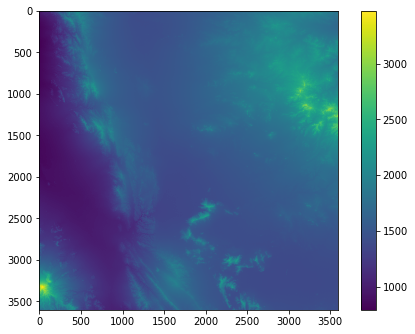

In [ ]:
plt.imshow(shasta_dem, interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
slope = rd.TerrainAttribute(shasta_dem, attrib='slope_radians')
rd.rdShow(slope, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

Exception: ignored

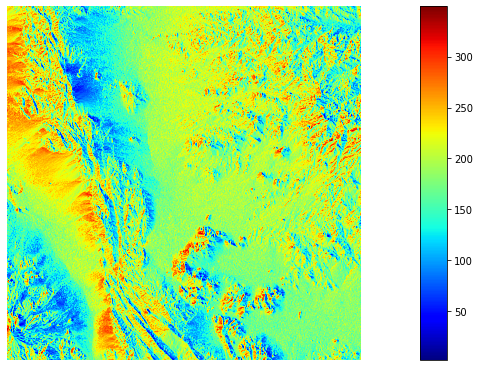

In [ ]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

# GDAL
richio was disapointing so we use gdal - spoiler alert: it will disapoint us as well because richio uses gdal

In [ ]:
dem = gdal.Open("/content/drive/MyDrive/Colab Notebooks/solar_radiation/dem.tif")

In [ ]:
slp= gdal.DEMProcessing('slope.tif',dem,'slope', computeEdges = True)

In [ ]:
slp_arr = slp.GetRasterBand(1).ReadAsArray()

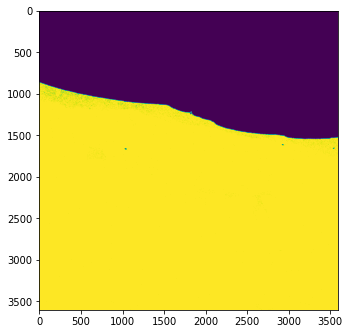

In [ ]:
plt.imshow(slp_arr)

# Alternative method
since GDAL is not giving us the proper slope and aspect we use arcgis to create these two then we imoport them

In [ ]:
!pip install rasterio

`dem.boudns` gives us the latitude and longitude that we can further use

In [ ]:
import rasterio
dem = rasterio.open('/content/drive/MyDrive/Colab Notebooks/solar_radiation/bazmandem.tif')
#left edge
long_left = dem.bounds[0]
print(long_left)
#bottom edge
lat_butt = dem.bounds[1]
print(lat_butt)
#right edge
long_right = dem.bounds[2]
print(long_right)
#top edge
lat_top = dem.bounds[3]
print(lat_top)

59.99986111111111
27.999861111111112
61.000138888888884
29.00013888888889


In [ ]:
type(dem)

rasterio.io.DatasetReader

## io to numpy array
to change the file into numpy we use `.read()` method

In [ ]:
dem =dem.read()

In [ ]:
type(dem)

numpy.ndarray

In [ ]:
dem.shape

(1, 3601, 3601)

In [ ]:
slp = rasterio.open('/content/drive/MyDrive/Colab Notebooks/solar_radiation/bazman_slope.tif')
asp = rasterio.open('/content/drive/MyDrive/Colab Notebooks/solar_radiation/bazman_aspect.tif')

In [ ]:
slp =slp.read()
asp =asp.read()

In [ ]:
print(slp.shape)
print(asp.shape)

(1, 3601, 3601)
(1, 3601, 3601)


as we can see our array have and extra dimentions, which is usfull when we have multiple bands, but now that we have only one band we use `np.squeez` to remove these extra dims

In [ ]:
dem = np.squeeze(dem)
slp = np.squeeze(slp)
asp = np.squeeze(asp)

In [ ]:
print(dem.shape)
print(slp.shape)
print(asp.shape)

(3601, 3601)
(3601, 3601)
(3601, 3601)


Text(0.5, 1.0, 'aspect')

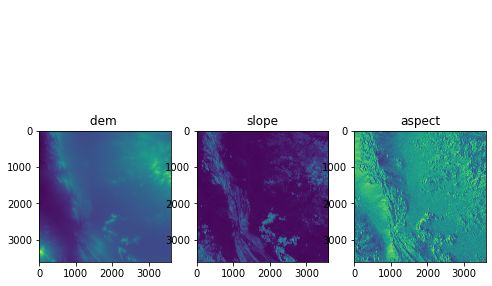

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = [20,5]
fig.suptitle(' ')
ax1.imshow(dem)
ax1.set_title('dem ')
ax2.imshow(slp)
ax2.set_title('slope')
ax3.imshow(asp)
ax3.set_title('aspect')

converting degrees to Radians so we could use them in SAVAGE algorithm

In [ ]:
slp_rad = np.radians(slp)

In [ ]:
print(f'pixel[1,1] in degrees is: {slp[1,1]} and in radians it is: {slp_rad[1,1]}')

pixel[1,1] in degrees is: 8.233658790588379 and in radians it is: 0.14370445907115936


In [ ]:
asp_rad = np.radians(asp)

In [ ]:
print(f'pixel[1,1] in degrees is: {asp[1,1]} and in radians it is: {asp_rad[1,1]}')

pixel[1,1] in degrees is: 168.6900634765625 and in radians it is: 2.944196939468384


In [ ]:
np.pi

3.141592653589793

In [ ]:
5/4

1.25

## calculating the folded aspect

In [ ]:
def folded_aspect(aspect):
  pi = np.pi
  folded = np.abs(pi-np.abs(aspect-(1.25*pi)))
  return folded

In [ ]:
fld_asp = folded_aspect(asp_rad)

# Latitude of each pixel
creating a raster containing

there are so many things going on in this function so I'll try to explain them all:

`np.linspace(start,stop,numer)`: so our latitude is the same for each row, what we do here is that with linspace we care only one column of the lat raster,
which is from `top_lat` to `buttom_lat` and with the step number of number of rows in original dem(in this case 3601)

`[:,None]` what this does it converst a row wise array into a column wise array

[np.tile()](https://stackoverflow.com/questions/21482728/how-to-fill-a-numpy-array-with-a-gradient-with-a-vectorized-code): what this does is it takse a row or column an it repreats it in rows or columns, with this now we can multiply our 1 column lat into width columns lat_raster


In [ ]:
dem.shape

(3601, 3601)

In [ ]:
np.arange(5)[:,None]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [ ]:
np.linspace(5,0,10)

array([5.        , 4.44444444, 3.88888889, 3.33333333, 2.77777778,
       2.22222222, 1.66666667, 1.11111111, 0.55555556, 0.        ])

In [ ]:
np.linspace(5,0,10)[:,None]

array([[5.        ],
       [4.44444444],
       [3.88888889],
       [3.33333333],
       [2.77777778],
       [2.22222222],
       [1.66666667],
       [1.11111111],
       [0.55555556],
       [0.        ]])

In [ ]:
def lat_raster(dem, top_lat,butt_lat):
  height,width = dem.shape
  column = np.linspace(top_lat,butt_lat,height)[:,None]
  lat_ras = np.tile(column,width)
  return lat_ras

make sure to convert your lat into radians (becuase savage algorithms expects all angles to be in radians)

In [ ]:
lat_top = np.radians(lat_top)
lat_butt = np.radians(lat_butt)

In [ ]:
lat_ras=lat_raster(dem,lat_top,lat_butt)

In [ ]:
lat_ras.shape

(3601, 3601)

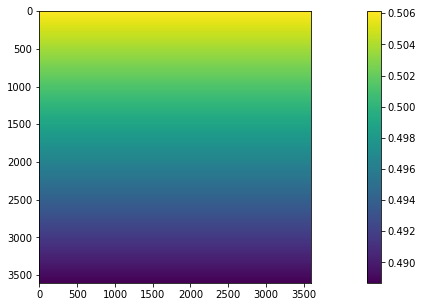

In [ ]:
plt.imshow(lat_ras)
plt.colorbar()
plt.show()

In [ ]:
from numpy import cos,sin

In [ ]:
def savage(latitude_raster,slope_raster,folded_aspect_raster):
  a = folded_aspect_raster
  l = latitude_raster
  s = slope_raster

  sr = 0.339 + 0.808*(cos(l)*cos(s)) - 0.19*(sin(l)*sin(s)) - 0.482*(cos(a)* sin(s))
  return sr


In [ ]:
svg= savage(lat_ras,slp_rad,fld_asp)

In [ ]:
print(np.min(svg),np.max(svg))

0.05220727640140577 1.15339902540734


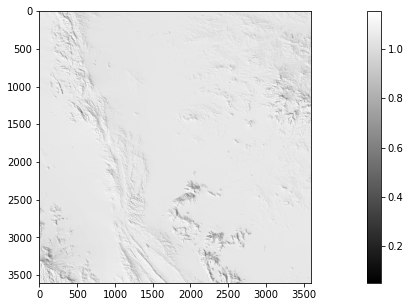

In [ ]:
plt.imshow(svg,cmap='gray')
plt.colorbar()

In [ ]:
import cv2 as cv
cv.imwrite('savage.png',svg*(255/np.max(svg)))

True

## Min-Max stretching of savage

In [ ]:
svg_st = (svg - np.min(svg))/(np.max(svg)-np.min(svg))
svg_st = svg_st*255

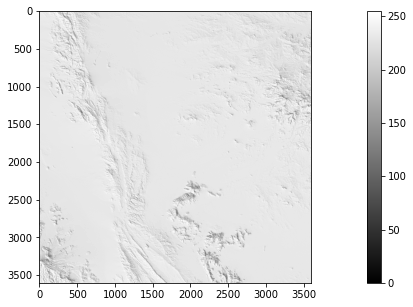

In [ ]:
plt.imshow(svg_st,cmap='gray')
plt.colorbar()

In [ ]:
cv.imwrite('savage_stretched.png',svg_st)

True